# Voting

In [57]:
import matplotlib
from preprocessing import *
from aux import *

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

sns.set()

df_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1i-KJ2lSvM7OQH0Yd59bX01VoZcq8Sglq')
df_decision = pd.read_csv('https://drive.google.com/uc?export=download&id=1km-AEIMnWVGqMtK-W28n59hqS5Kufhd0')

## Preprocesado 1

In [58]:
columnillas = ['tipo_de_sala_4d', 'tipo_de_sala_normal', 'tipo_de_sala_nan', 'id_usuario', 'genero_mujer', 'genero_nan', 
              'edad', 'amigos', 'parientes', 'precio_ticket', 'fila_medio', 'fila_nan',
              'nombre_sede_fiumark_palermo', 'nombre_sede_fiumark_quilmes', 'nombre_sede_nan', 
              'cant_acompañantes']

In [59]:
def preprocesado_1(dataset, columnas):
    df = eliminar_features_que_no_aportan_info(dataset, False)
    df = crear_feature_acompañantes(df)
    df = replace_nulls_column(df, 'edad', 'moda')
    features_a_encodear = ['nombre_sede','genero', 'tipo_de_sala', 'fila']
    df = encodear_atributos_categoricos(df, features_a_encodear)
    df = df.reindex(columns = columnas)
    return df

In [60]:
volver = ['volveria']

In [61]:
columnas = columnillas + volver

In [62]:
dataset = pd.merge(df_data, df_decision, how='inner', left_on='id_usuario', right_on='id_usuario')

In [63]:
df = preprocesado_1(dataset, columnas)

df.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,fila_medio,fila_nan,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,cant_acompañantes,volveria
0,1,0,0,117,0,0,73.5,0,0,1,0,1,0,1,0,0,0
1,1,0,0,658,1,0,35.0,1,1,2,0,1,0,1,0,2,0
2,0,1,0,794,0,0,27.0,0,0,3,0,1,0,0,0,0,0
3,1,0,0,455,0,0,27.0,0,0,1,0,1,1,0,0,0,0
4,1,0,0,173,1,0,4.0,1,1,2,0,1,1,0,0,2,1


In [64]:
df.shape

(801, 17)

## Entrenamiento

In [65]:
X, y = split_dataset_X_y(df, columnillas)

X.shape:  (801, 16)
y.shape:  (801,) 



In [66]:
params_arbol = {'max_depth': np.arange(1, 50),
                'min_samples_leaf': np.arange(1, 50),
                'criterion': ['gini', 'entropy']
               }

arbol = DecisionTreeClassifier(random_state=117)

best_params_arbol, X_train, X_test, y_train, y_test = fit_model_random_grid_search (X, y, arbol, params_arbol)

arbol  = DecisionTreeClassifier(max_depth=best_params_arbol['max_depth'],
                                min_samples_leaf=best_params_arbol['min_samples_leaf'],
                                criterion=best_params_arbol['criterion'],
                                random_state=117)

arbol = apply_stratified_k_fold(X, y, arbol)

Best score: 0.8552878965922444
Best params {'min_samples_leaf': 49, 'max_depth': 34, 'criterion': 'gini'}

Fold 0: AUC ROC score is 0.7116
Fold 1: AUC ROC score is 0.7062
Fold 2: AUC ROC score is 0.7988
Fold 3: AUC ROC score is 0.7780
Fold 4: AUC ROC score is 0.7597
Mean test AUC ROC is: 0.7509


In [67]:
params_forest = {'n_estimators': np.arange(1, 50),
                 'max_samples': np.arange(1, 50),
                 'min_samples_split': np.arange(2, 50),
                 'max_features': np.arange(1, 15),
                 'criterion': ['gini', 'entropy']
                }

forest = RandomForestClassifier(random_state=117)

best_params_forest, X_train, X_test, y_train, y_test = fit_model_random_grid_search (X, y, forest, params_forest)

forest = RandomForestClassifier(n_estimators=best_params_forest['n_estimators'],
                                min_samples_split=best_params_forest['min_samples_split'],
                                max_samples=best_params_forest['max_samples'],
                                max_features=best_params_forest['max_features'],
                                criterion=best_params_forest['criterion'],
                                random_state=117)

forest = apply_stratified_k_fold(X, y, forest)

Best score: 0.8536427732079908
Best params {'n_estimators': 27, 'min_samples_split': 7, 'max_samples': 44, 'max_features': 7, 'criterion': 'gini'}

Fold 0: AUC ROC score is 0.7549
Fold 1: AUC ROC score is 0.7446
Fold 2: AUC ROC score is 0.7792
Fold 3: AUC ROC score is 0.8039
Fold 4: AUC ROC score is 0.8097
Mean test AUC ROC is: 0.7785


In [68]:
params_ada = {'n_estimators': np.arange(25, 100),
              'learning_rate': [0.1, 0.2, 0.4, 0.7],
              'algorithm': ['SAMME', 'SAMME.R']
             }

ada = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(
    max_depth=3, min_samples_leaf=10,random_state=117, criterion="entropy"), random_state=117)

best_params_ada, X_train, X_test, y_train, y_test = fit_model_random_grid_search (X, y, ada, params_ada)

ada = AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10,random_state=117, criterion="entropy"),
    random_state = 117,
    n_estimators = best_params_ada['n_estimators'],
    learning_rate = best_params_ada['learning_rate'],
    algorithm = best_params_ada['algorithm'])

ada = apply_stratified_k_fold(X, y, ada)

Best score: 0.8586075205640423
Best params {'n_estimators': 38, 'learning_rate': 0.1, 'algorithm': 'SAMME'}

Fold 0: AUC ROC score is 0.7640
Fold 1: AUC ROC score is 0.7931
Fold 2: AUC ROC score is 0.8631
Fold 3: AUC ROC score is 0.7913
Fold 4: AUC ROC score is 0.7920
Mean test AUC ROC is: 0.8007


In [69]:
model_voting = VotingClassifier(
        estimators=[('arbol', arbol), ('forest', forest), ('ada', ada)], voting='soft'
    )

In [70]:
arbol.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=34, min_samples_leaf=49, random_state=117)

In [71]:
forest.fit(X_train, y_train)

RandomForestClassifier(max_features=7, max_samples=44, min_samples_split=7,
                       n_estimators=27, random_state=117)

In [72]:
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=3,
                                                         min_samples_leaf=10,
                                                         random_state=117),
                   learning_rate=0.1, n_estimators=38, random_state=117)

In [73]:
model_voting.fit(X_train, y_train)

VotingClassifier(estimators=[('arbol',
                              DecisionTreeClassifier(max_depth=34,
                                                     min_samples_leaf=49,
                                                     random_state=117)),
                             ('forest',
                              RandomForestClassifier(max_features=7,
                                                     max_samples=44,
                                                     min_samples_split=7,
                                                     n_estimators=27,
                                                     random_state=117)),
                             ('ada',
                              AdaBoostClassifier(algorithm='SAMME',
                                                 base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                       max_depth=3,
                                       

In [74]:
model_voting = apply_stratified_k_fold(X, y, model_voting)

Fold 0: AUC ROC score is 0.7398
Fold 1: AUC ROC score is 0.7471
Fold 2: AUC ROC score is 0.8284
Fold 3: AUC ROC score is 0.7913
Fold 4: AUC ROC score is 0.7758
Mean test AUC ROC is: 0.7765


## Métricas

In [75]:
scores = get_scores(model_voting, X_test, y_test)

AUC ROC : 0.8700
Accuracy : 0.7861
Precision : 0.8400
Recall : 0.9355
F1-Score : 0.6614


### Matriz de confusión

/home/anarella/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


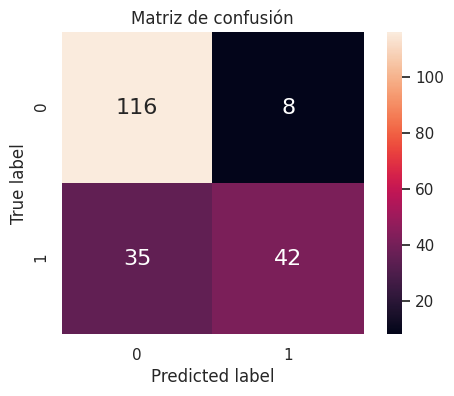

In [77]:
plot_confusion_matrix(y_test, model_voting.predict(X_test))

## Test Holdout

In [78]:
holdout = pd.read_csv('https://drive.google.com/uc?export=download&id=1I980-_K9iOucJO26SG5_M8RELOQ5VB6A')

In [79]:
df_h = preprocesado_1(holdout, columnillas)
df_h.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,fila_medio,fila_nan,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,cant_acompañantes
0,1,0,0,650,1,0,26.0,0,0,1,0,1,1,0,0,0
1,1,0,0,234,1,0,8.0,4,2,4,0,1,1,0,0,6
2,0,1,0,31,0,0,43.0,0,0,3,0,1,0,0,0,0
3,0,0,0,552,0,0,30.0,0,0,3,0,1,1,0,0,0
4,1,0,0,411,0,0,7.0,0,0,1,0,1,1,0,0,0


In [80]:
df_resultado = evaluate_holdout(holdout, df_h, model_voting)
df_resultado.head(15)

y_pred.shape:  (90,)
holdout_df.shape:  (90, 16) 



,id_usuario,volveria
0,650,0
1,234,0
2,31,0
3,552,0
4,411,0
5,134,1
6,497,1
7,434,0
8,528,1
9,112,1


In [81]:
df_resultado.to_csv('prediccion/voting_resultado_final.csv')

## Preprocesado 2

In [120]:
columnas_nuevas = ['tipo_de_sala_4d', 'tipo_de_sala_normal', 'tipo_de_sala_nan', 'id_usuario', 'genero_mujer', 'genero_nan', 
              'edad', 
                   'precio_ticket',
              'nombre_sede_fiumark_palermo', 'nombre_sede_fiumark_quilmes', 'nombre_sede_nan']
columnas_2 = columnas_nuevas + volver

In [121]:
def preprocesado_2(dataset, columnas):
    df = eliminar_features_que_no_aportan_info(dataset, True)
    df = eliminar_features(df, ['amigos','parientes'])
    df = replace_nulls_column(df, 'edad', 'moda')
    features_a_encodear = ['nombre_sede','genero', 'tipo_de_sala']
    df = encodear_atributos_categoricos(df, features_a_encodear)
    df = normalizar_atributos_numericos(df)
    df = df.reindex(columns = columnas)
    return df

In [122]:
df_2 = preprocesado_2(dataset, columnas_2)
df_2.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,volveria
0,1,0,0,0.130337,0,0,0.880653,0.000000,0,1,0,0.0
1,1,0,0,0.738202,1,0,0.396985,0.020408,0,1,0,0.0
2,0,1,0,0.891011,0,0,0.296482,0.040816,0,0,0,0.0
3,1,0,0,0.510112,0,0,0.296482,0.000000,1,0,0,0.0
4,1,0,0,0.193258,1,0,0.007538,0.020408,1,0,0,1.0


In [123]:
df_2.shape

(801, 12)

# Entrenamiento

In [124]:
X_2, y_2 = split_dataset_X_y(df_2, columnas_nuevas)

X.shape:  (801, 11)
y.shape:  (801,) 



In [125]:
arbol_2 = DecisionTreeClassifier(random_state=117)

best_params_arbol_2, X_train_2, X_test_2, y_train_2, y_test_2 = fit_model_random_grid_search (X_2, y_2, arbol_2, params_arbol)

arbol_2  = DecisionTreeClassifier(max_depth=best_params_arbol_2['max_depth'],
                                min_samples_leaf=best_params_arbol_2['min_samples_leaf'],
                                criterion=best_params_arbol_2['criterion'],
                                random_state=117)

arbol_2 = apply_stratified_k_fold(X_2, y_2, arbol_2)

Best score: 0.8446239717978848
Best params {'min_samples_leaf': 28, 'max_depth': 28, 'criterion': 'entropy'}

Fold 0: AUC ROC score is 0.7197
Fold 1: AUC ROC score is 0.7793
Fold 2: AUC ROC score is 0.7957
Fold 3: AUC ROC score is 0.7799
Fold 4: AUC ROC score is 0.8140
Mean test AUC ROC is: 0.7777


In [126]:
params_forest_2 = {'n_estimators': np.arange(1, 50),
                 'max_samples': np.arange(1, 50),
                 'min_samples_split': np.arange(2, 50),
                 'max_features': np.arange(1, 10),
                 'criterion': ['gini', 'entropy']
                }

forest_2 = RandomForestClassifier(random_state=117)

best_params_forest_2, X_train_2, X_test_2, y_train_2, y_test_2 = fit_model_random_grid_search (X_2, y_2, forest_2, params_forest_2)

forest_2 = RandomForestClassifier(n_estimators=best_params_forest_2['n_estimators'],
                                min_samples_split=best_params_forest_2['min_samples_split'],
                                max_samples=best_params_forest_2['max_samples'],
                                max_features=best_params_forest_2['max_features'],
                                criterion=best_params_forest_2['criterion'],
                                random_state=117)

forest_2 = apply_stratified_k_fold(X_2, y_2, forest_2)

Best score: 0.8559048178613395
Best params {'n_estimators': 29, 'min_samples_split': 21, 'max_samples': 47, 'max_features': 3, 'criterion': 'entropy'}

Fold 0: AUC ROC score is 0.7367
Fold 1: AUC ROC score is 0.7149
Fold 2: AUC ROC score is 0.7206
Fold 3: AUC ROC score is 0.7559
Fold 4: AUC ROC score is 0.7210
Mean test AUC ROC is: 0.7298


In [127]:
ada_2 = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(
    max_depth=3, min_samples_leaf=10,random_state=117, criterion="entropy"), random_state=117)

best_params_ada_2, X_train_2, X_test_2, y_train_2, y_test_2 = fit_model_random_grid_search (X_2, y_2, ada_2, params_ada)

ada_2 = AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10,random_state=117, criterion="entropy"),
    random_state = 117,
    n_estimators = best_params_ada_2['n_estimators'],
    learning_rate = best_params_ada_2['learning_rate'],
    algorithm = best_params_ada_2['algorithm'])

ada_2 = apply_stratified_k_fold(X_2, y_2, ada_2)

Best score: 0.8626028202115158
Best params {'n_estimators': 90, 'learning_rate': 0.1, 'algorithm': 'SAMME'}

Fold 0: AUC ROC score is 0.7378
Fold 1: AUC ROC score is 0.7793
Fold 2: AUC ROC score is 0.8203
Fold 3: AUC ROC score is 0.7925
Fold 4: AUC ROC score is 0.7767
Mean test AUC ROC is: 0.7813


In [128]:
model_voting_2 = VotingClassifier(
        estimators=[('arbol', arbol_2), ('forest', forest_2), ('ada', ada_2)], voting='soft'
    )

In [129]:
arbol_2.fit(X_train_2, y_train_2)

DecisionTreeClassifier(criterion='entropy', max_depth=28, min_samples_leaf=28,
                       random_state=117)

In [130]:
forest_2.fit(X_train_2, y_train_2)

RandomForestClassifier(criterion='entropy', max_features=3, max_samples=47,
                       min_samples_split=21, n_estimators=29, random_state=117)

In [131]:
ada_2.fit(X_train_2, y_train_2)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=3,
                                                         min_samples_leaf=10,
                                                         random_state=117),
                   learning_rate=0.1, n_estimators=90, random_state=117)

In [132]:
model_voting_2.fit(X_train_2, y_train_2)

VotingClassifier(estimators=[('arbol',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=28,
                                                     min_samples_leaf=28,
                                                     random_state=117)),
                             ('forest',
                              RandomForestClassifier(criterion='entropy',
                                                     max_features=3,
                                                     max_samples=47,
                                                     min_samples_split=21,
                                                     n_estimators=29,
                                                     random_state=117)),
                             ('ada',
                              AdaBoostClassifier(algorithm='SAMME',
                                                 base_estimator=DecisionTreeClassifier(criterion='

In [133]:
model_voting_2 = apply_stratified_k_fold(X_2, y_2, model_voting_2)

Fold 0: AUC ROC score is 0.6995
Fold 1: AUC ROC score is 0.7894
Fold 2: AUC ROC score is 0.8089
Fold 3: AUC ROC score is 0.7749
Fold 4: AUC ROC score is 0.7920
Mean test AUC ROC is: 0.7729


## Métricas

In [134]:
scores_2 = get_scores(model_voting_2, X_test_2, y_test_2)

AUC ROC : 0.8757
Accuracy : 0.8109
Precision : 0.8421
Recall : 0.9274
F1-Score : 0.7164


### Matriz de confusión

/home/anarella/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0.0, 1.0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


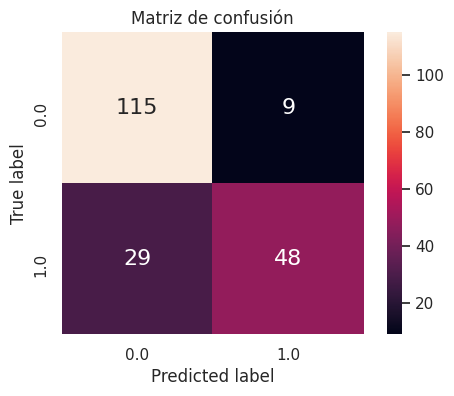

In [135]:
plot_confusion_matrix(y_test_2, model_voting_2.predict(X_test_2))

## Test Holdout

In [136]:
df_h_2 = preprocesado_2(holdout, columnas_nuevas)
df_h_2.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan
0,1,0,0,0.751756,1,0,0.344774,0.000000,1,0,0
1,1,0,0,0.264637,1,0,0.063963,0.061224,1,0,0
2,0,1,0,0.026932,0,0,0.609984,0.040816,0,0,0
3,0,0,0,0.637002,0,0,0.407176,0.040816,1,0,0
4,1,0,0,0.471897,0,0,0.048362,0.000000,1,0,0


In [137]:
df_resultado_2 = evaluate_holdout(holdout, df_h_2, model_voting_2)
df_resultado_2.head(15)

y_pred.shape:  (90,)
holdout_df.shape:  (90, 11) 



,id_usuario,volveria
0,650,0
1,234,1
2,31,0
3,552,0
4,411,0
5,134,1
6,497,1
7,434,0
8,528,1
9,112,1


In [138]:
df_resultado_2.to_csv('prediccion/voting_2do_prepoc_resultado_final.csv')